#### Read the dataframe from the url


In [1]:
class dataframe_functions:
  def convert_to_datetime(self,string_list,string_format):
    ''' Takes as input a list os date stings and returns the list in datetime format 
    Input Format : %Y - Year
                  %d - day
                  %m - Month
                  %H - Hour
                  %M - Minute
                  % S- Second
                  %f - Millisecond
   Eg : 2020-02-24 : "%Y-%m-%d"
   '''
    from datetime import datetime
    date_list=[]
    
    for date in string_list:
      date_list.append(datetime.strptime(date,string_format))
    return date_list

  def convert_to_str(self,date_list,string_format):
    ''' Returns the string format of the date list provided
     Input Format : %Y - Year
                  %d - day
                  %m - Month
                  %H - Hour
                  %M - Minute
                  % S- Second
                  %f - Millisecond
   Eg : 2020-02-24 : "%Y-%m-%d"'''
   
    from datetime import datetime
    string_list=[]
    for date in date_list:
      string_list.append(date.strftime(string_format))
    return string_list

  def drop_objects(self,dataFrame):
    import pandas as pd
    drop_columns=[]
    for column in dataFrame.columns:
      if dataFrame[column].dtype=='object':
        drop_columns.append(column)
    dataFrame.drop(drop_columns,axis=1,inplace=True)

 




In [2]:
def return_dates(start,end):
  dates=[]
  start_date=datetime.strptime(start,'%d-%m-%Y')
  dates.append(start_date)

  start_date=start_date+timedelta(days=31)
  dates.append(start_date)

  end_date=datetime.strptime(end,'%d-%m-%Y')
  temp_date=start_date

  while start_date<end_date:
    last_day=calendar.monthrange(start_date.year,start_date.month)
    last_day=datetime.strptime(str(last_day[1])+'-'+str(start_date.month)+'-'+str(start_date.year),'%d-%m-%Y')
    dates.append(last_day)
    last_day=last_day+timedelta(days=1)
    start_date=last_day
  # Now we have got the dates extracted as per requirement
  dates=dates[:-1]
  return dates

def filter_by_date(data,dates):
  filtered=pd.DataFrame(columns=data.columns)
  for date in dates:
    filtered=filtered.append(data[data.index==date],ignore_index=True)
  return filtered

In [3]:
import pandas as pd
from datetime import datetime,timedelta
import calendar
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
try:
    covid_data=pd.read_csv('covid_data.csv')
    print('Offline file loaded')
except:
    print('Downloading from website')
    covid_data=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
df_function=dataframe_functions()
# Since the date is of datatype string converting it into datetime object so that it is easy to compare
covid_data['date_formatted']=df_function.convert_to_datetime(covid_data['date'],"%Y-%m-%d")

# Filling the missing values with 0
for column in covid_data.columns:
  if covid_data[column].dtype!='object':
    covid_data[column]=covid_data[column].fillna(0)

# Grouping by date
grouped_data=covid_data.groupby(by='date_formatted').sum()

Offline file loaded


#### Plot of death toll by date

In [6]:
dates=[]
start_date=datetime.strptime('01-01-2020','%d-%m-%Y')
dates.append(start_date)

start_date=start_date+timedelta(days=31)
dates.append(start_date)

end_date=datetime.strptime('21-12-2021','%d-%m-%Y')
temp_date=start_date
while start_date<end_date:
  last_day=calendar.monthrange(start_date.year,start_date.month)
  last_day=datetime.strptime(str(last_day[1])+'-'+str(start_date.month)+'-'+str(start_date.year),'%d-%m-%Y')
  dates.append(last_day)
  last_day=last_day+timedelta(days=1)
  start_date=last_day
 # Now we have got the dates extracted as per requirement
dates=dates[:-1]


# Creating a dataframe
grouped_dataframe=pd.DataFrame(columns=grouped_data.columns)
for date in dates:
  grouped_dataframe=grouped_dataframe.append(grouped_data[grouped_data.index==date],ignore_index=True)
    
dates=df_function.convert_to_str(dates,'%d-%m-%Y')

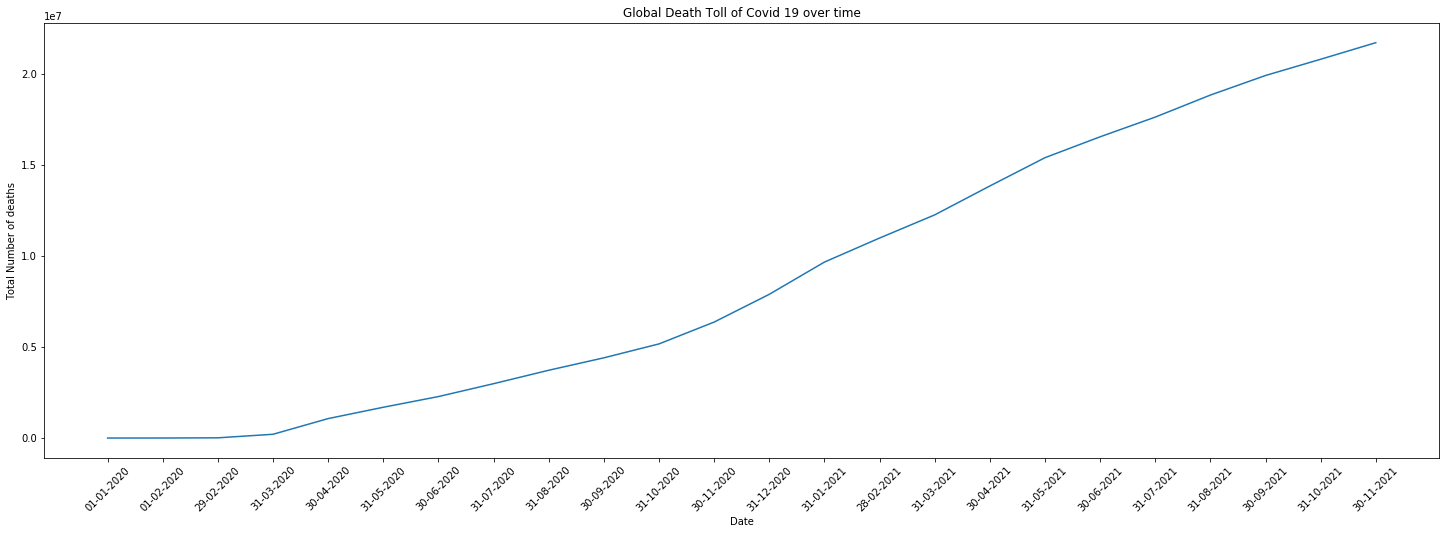

In [7]:
plt.figure(figsize=(25,8))
plt.title('Global Death Toll of Covid 19 over time')
plt.ylabel('Total Number of deaths')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(dates,grouped_dataframe['total_deaths'])

#### Simple Linear Regression

In [8]:
def preprocess_data(data):
  y=data['total_cases']
  dates=data['date_formatted']
  x=data.drop(['total_cases'],axis=1)
  # Selecting few columns based on their desrcriptions available
  # Excluding the smoothened values and testing rates

  columns=['icu_patients','hosp_patients','total_vaccinations','population_density'\
           ,'total_tests','median_age','extreme_poverty','cardiovasc_death_rate',\
           'diabetes_prevalence','handwashing_facilities','hospital_beds_per_thousand']

  x=x[columns]
  return x,y,dates

def filter_by_dates(data,start_date,end_date,column_name):
  data=data[(data[column]>=start_date)& (data[column]<=end_date)]
  return data

In [9]:
# Finding the date when the first covid death occured
start_date=None
for i,row in grouped_data.iterrows():
  if row['total_deaths']>0:
    start_date=i
    break
end_date=grouped_data.iloc[-5].name

# Filtering the dataset by dates
data=grouped_data.reset_index()
data=filter_by_dates(data,start_date,end_date,'date_formatted')

# Removing columns after going through the data descriptions
x,y,x_dates=preprocess_data(data)

# Prediction with the features other than date

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text xticklabel objects>)

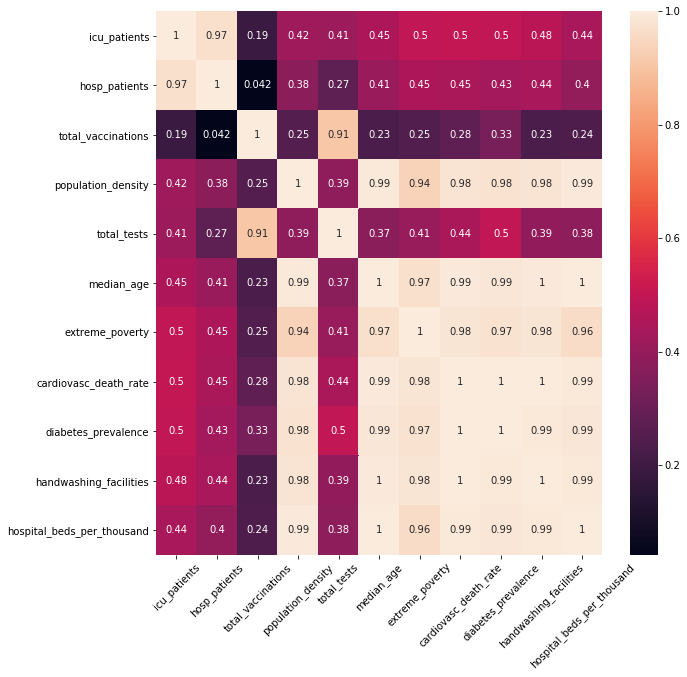

In [14]:
# Finding correaltion of the columns
corr=x.corr()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)
plt.xticks(rotation=45)

In [59]:
# The last few columns has very high correlation with a lot of other parameters. Hence dropping them

columns_needed=[]
for column in corr.columns:
  for idx in corr.index:
    if corr.loc[idx][column]>0.98:
      if column!=idx:
        columns_needed.append(column)
        print(column,' and ',idx,' has ', corr.loc[idx][column]*100,'% correlation')

population_density  and  median_age  has  98.95135150838776 % correlation
population_density  and  hospital_beds_per_thousand  has  99.46785138569837 % correlation
median_age  and  population_density  has  98.95135150838776 % correlation
median_age  and  cardiovasc_death_rate  has  99.32368222468466 % correlation
median_age  and  diabetes_prevalence  has  98.66852654987073 % correlation
median_age  and  handwashing_facilities  has  99.54223180198697 % correlation
median_age  and  hospital_beds_per_thousand  has  99.83007104128336 % correlation
extreme_poverty  and  cardiovasc_death_rate  has  98.48181107775872 % correlation
extreme_poverty  and  handwashing_facilities  has  98.4341716236581 % correlation
cardiovasc_death_rate  and  median_age  has  99.32368222468466 % correlation
cardiovasc_death_rate  and  extreme_poverty  has  98.48181107775872 % correlation
cardiovasc_death_rate  and  diabetes_prevalence  has  99.64925363466088 % correlation
cardiovasc_death_rate  and  handwashing_f

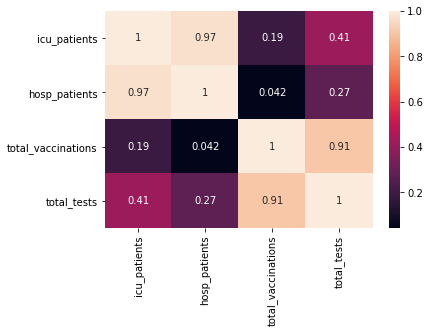

In [60]:
columns_needed=list(set(columns_needed))
x=x.drop(columns_needed,axis=1)
corr=x.corr()
sns.heatmap(corr,annot=True)

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=1)


lr=LinearRegression()
lr.fit(x_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [62]:
y_pred=lr.predict(x)

In [63]:
x.index=x_dates
x['Predictions']=y_pred
x['Actual']=y.values

In [64]:
# Summarising the data for presentation
dates=[]
start_date=datetime.strptime('01-01-2020','%d-%m-%Y')
dates.append(start_date)

start_date=start_date+timedelta(days=31)
dates.append(start_date)

end_date=datetime.strptime('21-12-2021','%d-%m-%Y')
temp_date=start_date
while start_date<end_date:
  last_day=calendar.monthrange(start_date.year,start_date.month)
  last_day=datetime.strptime(str(last_day[1])+'-'+str(start_date.month)+'-'+str(start_date.year),'%d-%m-%Y')
  dates.append(last_day)
  last_day=last_day+timedelta(days=1)
  start_date=last_day
 # Now we have got the dates extracted as per requirement
dates=dates[:-1]



In [65]:
# Creating a dataframe
grouped_dataframe=pd.DataFrame(columns=x.columns)
for date in dates:
  grouped_dataframe=grouped_dataframe.append(x[x.index==date],ignore_index=True)
    
dates=df_function.convert_to_str(dates,'%d-%m-%Y')
dates=dates[1:]

In [66]:
grouped_dataframe.index=dates

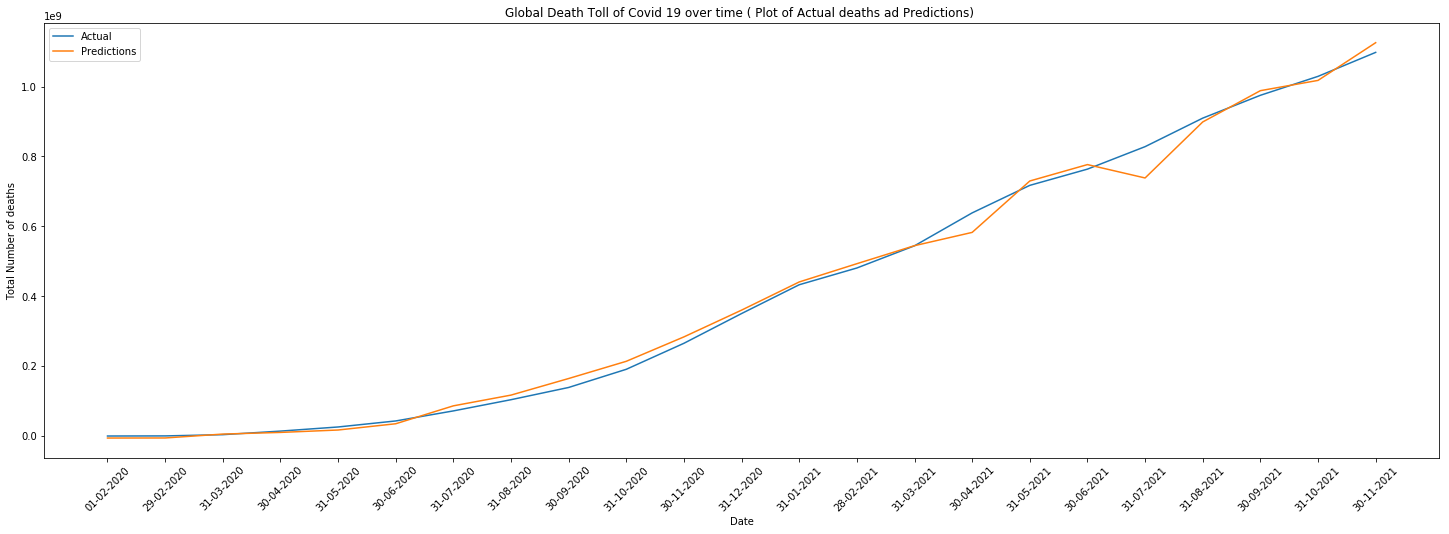

In [67]:
plt.figure(figsize=(25,8))
plt.title('Global Death Toll of Covid 19 over time ( Plot of Actual deaths ad Predictions) ')
plt.ylabel('Total Number of deaths')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(grouped_dataframe['Actual'])
plt.plot(grouped_dataframe['Predictions'])
plt.legend(['Actual','Predictions'])

In [44]:
#Equation of the line
import numpy as np
np.round(lr.coef_,0),np.round(lr.intercept_,0)

(array([2953., -417.,   -0.,    0.]), -5737109.0)

## The equation is of the form
y=2953*icu_patients - 417 *hosp_patients -5734792

In [45]:
from sklearn.metrics import mean_squared_error
print(' The mean square error is ',end=' ')
mean_squared_error(grouped_dataframe['Predictions'],grouped_dataframe['Actual'])

 The mean square error is  

656725020009438.4

#Doing the prediction with dates

# Prediction with date

In [46]:
import pandas as pd
from datetime import datetime,timedelta
import calendar
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
try:
    covid_data=pd.read_csv('covid_data.csv')
    print('Offline file loaded')
except:
    print('Downloading from website')
    covid_data=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
    
df_function=dataframe_functions()
# Since the date is of datatype string converting it into datetime object so that it is easy to compare
covid_data['date_formatted']=df_function.convert_to_datetime(covid_data['date'],"%Y-%m-%d")

# Filling the missing values with 0
for column in covid_data.columns:
  if covid_data[column].dtype!='object':
    covid_data[column]=covid_data[column].fillna(0)

# Grouping by date
grouped_data=covid_data.groupby(by='date_formatted').sum()
dates=[]
start_date=datetime.strptime('01-01-2020','%d-%m-%Y')
dates.append(start_date)

start_date=start_date+timedelta(days=31)
dates.append(start_date)

end_date=datetime.strptime('21-12-2021','%d-%m-%Y')
temp_date=start_date
while start_date<end_date:
  last_day=calendar.monthrange(start_date.year,start_date.month)
  last_day=datetime.strptime(str(last_day[1])+'-'+str(start_date.month)+'-'+str(start_date.year),'%d-%m-%Y')
  dates.append(last_day)
  last_day=last_day+timedelta(days=1)
  start_date=last_day
 # Now we have got the dates extracted as per requirement
dates=dates[:-1]
# Creating a dataframe
grouped_dataframe=pd.DataFrame(columns=grouped_data.columns)
for date in dates:
  grouped_dataframe=grouped_dataframe.append(grouped_data[grouped_data.index==date],ignore_index=True)
    
dates=df_function.convert_to_str(dates,'%d-%m-%Y')

Offline file loaded


In [47]:
# Finding the date when the first covid death occured
start_date=None
for i,row in grouped_data.iterrows():
  if row['total_deaths']>0:
    start_date=i
    break
end_date=grouped_data.iloc[-5].name

# Filtering the dataset by dates
data=grouped_data.reset_index()
data=filter_by_dates(data,start_date,end_date,'date_formatted')

# Removing columns after going through the data descriptions
x,y,x_dates=preprocess_data(data)

In [48]:
x.index=x_dates
x_julian=np.array(x.index.to_julian_date()).reshape(x.shape[0],1)

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x_train,x_test,y_train,y_test=train_test_split(x_julian,y,test_size=0.25,random_state=1)


lr=LinearRegression()
lr.fit(x_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [50]:
y_pred=lr.predict(x_julian)

In [ ]:
x.index=x_dates
x['Predictions']=y_pred
x['Actual']=y.values

In [ ]:
# Summarising the data for presentation
dates=[]
start_date=datetime.strptime('01-01-2020','%d-%m-%Y')
dates.append(start_date)

start_date=start_date+timedelta(days=31)
dates.append(start_date)

end_date=datetime.strptime('21-12-2021','%d-%m-%Y')
temp_date=start_date
while start_date<end_date:
  last_day=calendar.monthrange(start_date.year,start_date.month)
  last_day=datetime.strptime(str(last_day[1])+'-'+str(start_date.month)+'-'+str(start_date.year),'%d-%m-%Y')
  dates.append(last_day)
  last_day=last_day+timedelta(days=1)
  start_date=last_day
 # Now we have got the dates extracted as per requirement
dates=dates[:-1]



In [ ]:
# Creating a dataframe
grouped_dataframe=pd.DataFrame(columns=x.columns)
for date in dates:
  grouped_dataframe=grouped_dataframe.append(x[x.index==date],ignore_index=True)
    
dates=df_function.convert_to_str(dates,'%d-%m-%Y')
dates=dates[1:]

In [ ]:
grouped_dataframe.index=dates


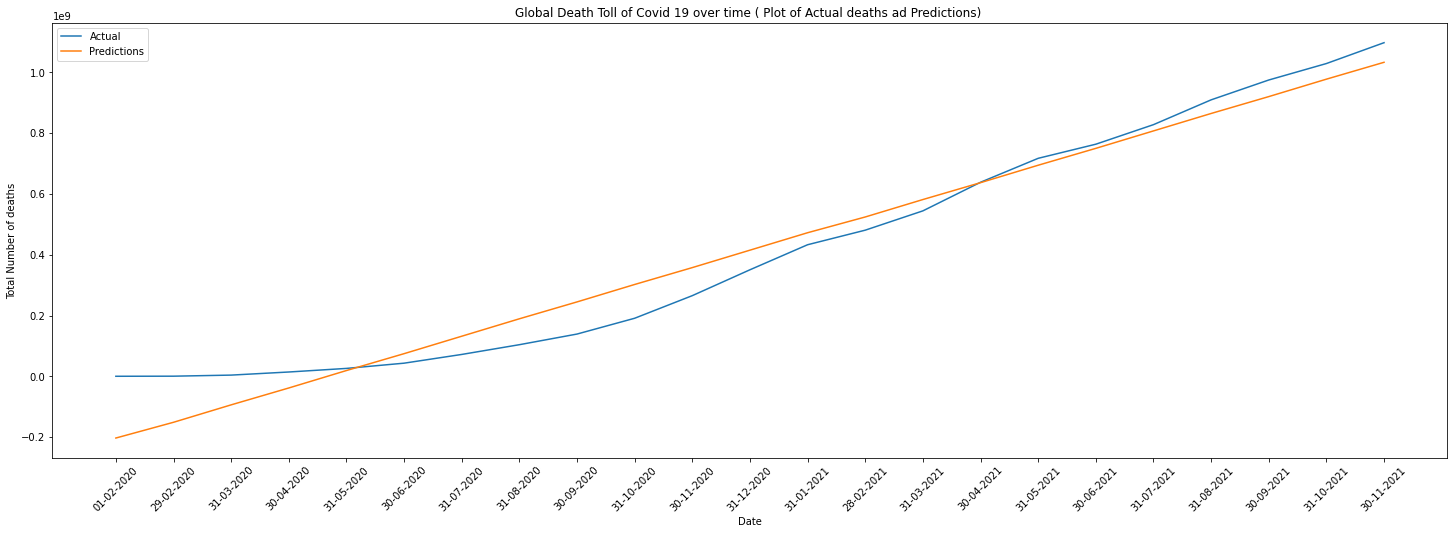

In [ ]:
plt.figure(figsize=(25,8))
plt.title('Global Death Toll of Covid 19 over time ( Plot of Actual deaths ad Predictions) ')
plt.ylabel('Total Number of deaths')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(grouped_dataframe['Actual'])
plt.plot(grouped_dataframe['Predictions'])
plt.legend(['Actual','Predictions'])

In [ ]:
#Equation of the line
import numpy as np
np.round(lr.coef_,0),np.round(lr.intercept_,0)

(array([1851193.]), -4552064635100.0)

## The equation is of the form
y=1851193*julian_dates  -4552064635100.0

In [ ]:
from sklearn.metrics import mean_squared_error
print(' The mean square error is ',end=' ')
mean_squared_error(grouped_dataframe['Predictions'],grouped_dataframe['Actual'])

 The mean square error is  

6198946408592542.0

#### Looking at the predictions, there are values which are extemely difficult. Eg : There are negative values which vary extrely with the actual values. But on summarising the data as in the above graph, it seems to be cancelling out to get the results as in the graph

# South Korea Analysis

##Generating the training data


In [120]:
def preprocess_korea(data):
    # Selecting the columns intuitevely 
    required_columns=['icu_patients','positive_rate','total_vaccinations','stringency_index','gdp_per_capita','median_age']
    data=data[required_columns]
    from sklearn.preprocessing import StandardScaler
    ss=StandardScaler()
    columns=data.columns
    df=pd.DataFrame(ss.fit_transform(data))
    df.columns=columns
    return df

In [121]:
import pandas as pd
from datetime import datetime,timedelta
import calendar
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

try:
    covid_data=pd.read_csv('covid_data.csv')
    print('Offline file loaded')
except:
    print('Downloading from website')
    covid_data=pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
    
    
df_function=dataframe_functions()
# Since the date is of datatype string converting it into datetime object so that it is easy to compare
covid_data['date_formatted']=df_function.convert_to_datetime(covid_data['date'],"%Y-%m-%d")

# Filling the missing values with 0
for column in covid_data.columns:
  if covid_data[column].dtype!='object':
    covid_data[column]=covid_data[column].fillna(0)

# Filtering out the data only for South Korea
covid_data=covid_data[covid_data['location']=='South Korea']

Offline file loaded


In [122]:
df_function.drop_objects(covid_data) # Dropping the object datatype columns
covid_data.drop(covid_data.columns[0],axis=1,inplace=True)

In [123]:
# Using groupby to remove multiple entries
sk_grouped=covid_data.groupby(by='date_formatted').sum() 


In [124]:
# Preparing the train and test data as specified
train_data=sk_grouped[(sk_grouped.index>='2020-09-01') &(sk_grouped.index<='2020-11-22') ]
test_data=sk_grouped[(sk_grouped.index>='2020-11-23') &(sk_grouped.index<='2020-11-29') ]
combine=[train_data,test_data]

In [125]:
# Saving the dates for future use
train_dates=train_data.index
test_dates=test_data.index

for data in combine:
  df_function.drop_objects(data)

x_train=train_data.drop(['total_deaths'],axis=1)
y_train=train_data['total_deaths']
x_test=test_data.drop(['total_deaths'],axis=1)
y_test=test_data['total_deaths']

/home/blink/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [110]:
x_train_=preprocess_korea(x_train)
x_test_=preprocess_korea(x_test)

In [126]:
# Creating a model with the training data
# Creating a linear regression model
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)
print(lr.score(x_train,y_train),'% train accuracy')
print(lr.score(x_test,y_test),' % test accuracy')

0.9999999387218423 % train accuracy
0.9999863578839603  % test accuracy


In [127]:
x_test['Predictions']=y_pred
x_test['date']=test_dates
x_test['Actual']=y_test.values


In [128]:
grouped_data=x_test.groupby(by='date').sum()

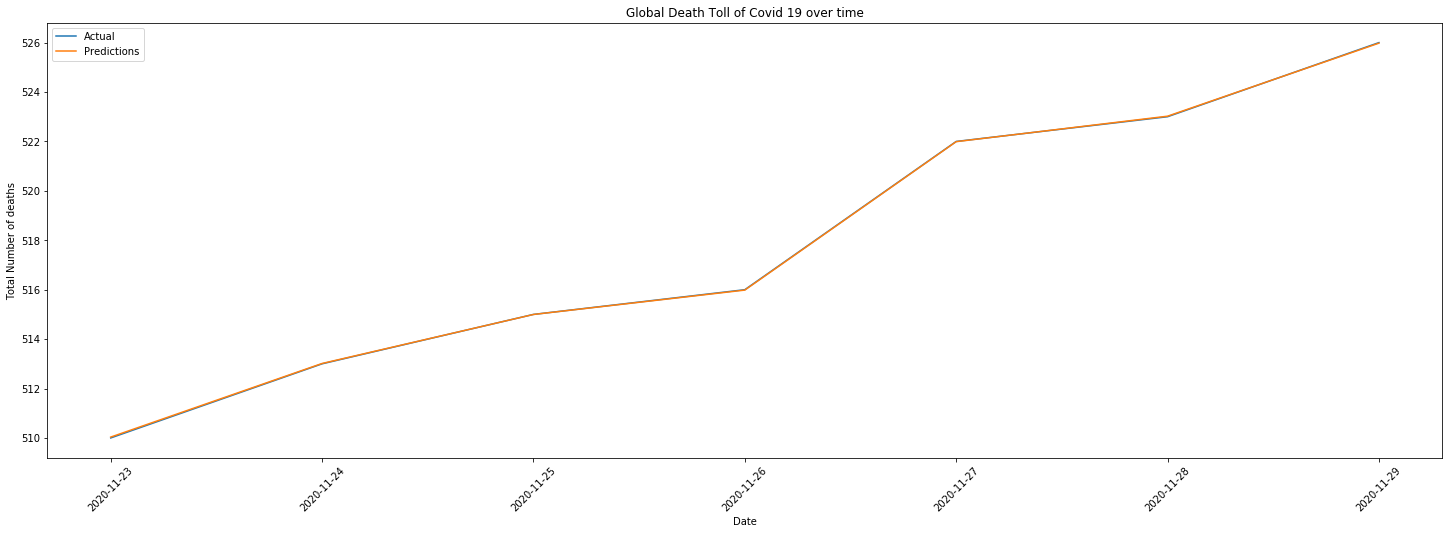

In [129]:
# PLotting the graphs
plt.figure(figsize=(25,8))
plt.title('Global Death Toll of Covid 19 over time')
plt.ylabel('Total Number of deaths')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(grouped_data['Actual'])
plt.plot(grouped_data['Predictions'])
plt.legend(['Actual','Predictions'])

In [130]:
# Calculating the RMSE

In [131]:
def rmse(predictions, targets):
  import numpy as np
  return ((predictions - targets) ** 2).mean()

In [133]:
#Calculating the Mean Square Error
from sklearn.metrics import mean_squared_error

print('Mean Square Error of the model is ',end='')
print(mean_squared_error(y_test,y_pred))

Mean Square Error of the model is 0.0004031384495047172
